<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Calibrated-Recommendations" data-toc-modified-id="Calibrated-Recommendations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Calibrated Recommendations</a></span><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Deep-Dive-Into-Calibrated-Recommendation" data-toc-modified-id="Deep-Dive-Into-Calibrated-Recommendation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Deep Dive Into Calibrated Recommendation</a></span><ul class="toc-item"><li><span><a href="#Calibration-Metric" data-toc-modified-id="Calibration-Metric-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Calibration Metric</a></span></li><li><span><a href="#Generating-Calibrated-Recommendations" data-toc-modified-id="Generating-Calibrated-Recommendations-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Generating Calibrated Recommendations</a></span></li></ul></li><li><span><a href="#End-Note" data-toc-modified-id="End-Note-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>End Note</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', '..', 'notebook_format'))

from formats import load_style
load_style(css_style='custom2.css', plot_style=False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from implicit.bpr import BayesianPersonalizedRanking
from implicit.evaluation import train_test_split, precision_at_k

%watermark -a 'Ethen' -d -t -v -p scipy,numpy,pandas,matplotlib,implicit

Ethen 2018-10-17 10:09:55 

CPython 3.6.4
IPython 6.4.0

scipy 1.1.0
numpy 1.14.1
pandas 0.23.0
matplotlib 2.2.2
implicit 0.3.8


# Calibrated Recommendations

When a user has watched, say, 70% romance movies and 30% action movies in the past, then it is reasonable to expect the personalized list of recommended movies to be comprised of 70% romance and 30% action movies as well since we would like to cover the user's diverse set of interests. A recommendation that actually reflect most if not all of the user's interest is considered a **Calibrated Recommendation**. But the question is, does our recommendation exhibit this trait?

Recommendation algorithm provides personalized user experience past on the user's past historical interaction with the product/system/website. However, when serving the recommendation such as recommendation top 10 movies that we think the user might be interested in, a recommendation engine that is solely measured based on ranking metrics can easily generate recommendations that focus on the main area of interests, resulting the user's other area of interest to be under-represented, or worse, absent in the final recommendation.

To hit the notion home, using the example above, given a user that has watched 70% romance movies and 30% action movies, if we were to solely measure the metric based on precision, we can say we can achieve the best performance by predicting the majority genre, i.e. we will recommend 100% romance movies and we can expect the user to interact with those recommendations 70% of the time. On other other hand, if we were to recommend 70% romance movies and 30% action movies, then we would expect our recommendation to only be correct 0.7 * 0.7 + 0.3 * 0.3 = 58% of the time.

Throughout the rest of this notebook, we will take a look at if the phenomenon of crowding out user's sub-interest occurs with our recommendation, develop a quantitative metric to measure how severe this issue is and implement a post-preprocessing logic that is agnostic of the underlying recommendation algorithm we decided to use to ensure the recommendation becomes more calibrated.

## Preparation

We'll be using the publicly available movielens-20m dataset throughout this experiment. We can download it via the following [link](https://www.kaggle.com/grouplens/movielens-20m-dataset). There's multiple data under that folder, we can select download all to make things easier.

The algorithm that we will be using to generate the recommendation is Bayesian Personalized Ranking, which is a matrix factorization based collaborative filtering algorithm. The reader doesn't need to be acquainted with this model per se to continue with the rest of this notebook as the discussion is model-agnostic and we'll be explaining the syntax. That said, this [link](https://github.com/ethen8181/machine-learning#recsys--20161217) contains some resources on this algorithm if it is of interest.

Given the dataset and the algorithm the preparation step we'll be doing in the next few code chunks is this:
- The raw `rating.csv` contains user's rating for each movie. Here, we will focus on implicit data, and follow the usual procedure of simulating binary implicit feedback data (i.e. whether the user enjoyed the movie) by retaining only ratings of 4 stars and higher, while dropping lower ratings.
- The raw `movie.csv` contains each movies genre tag. We will also eliminate movies that had no genre information attached and create a mapping that stores each movies' genre distribution. In this dataset, each movie $i$ typically has several genres $g$ associated with it, thus we assign equal probabilities $p(g|i)$ to each genre such that $\sum_g p(g|i) = 1$ for each movie $i$. This genre distribution will play a strong role in determining whether our recommendation is well calibrated or not.

In [2]:
data_dir = 'movielens-20m-dataset'

# we are working with movie data, but we'll name
# the movie as item to make it more generic to
# all use-cases
user_col = 'userId'
item_col = 'movieId'
value_col = 'rating'
time_col = 'timestamp'

rating_path = os.path.join(data_dir, 'rating.csv')
df_raw = pd.read_csv(rating_path)
print('dimension: ', df_raw.shape)
df_raw.head()

dimension:  (20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [3]:
title_col = 'title'
genre_col = 'genres'

item_info_path = os.path.join(data_dir, 'movie.csv')
df_item = pd.read_csv(item_info_path)
df_item = df_item[df_item[genre_col] != '(no genres listed)']
print('dimension: ', df_item.shape)
df_item.head()

dimension:  (27032, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
class Item:
    """
    Data holder for our item.
    
    Parameters
    ----------
    id : int
  
    title : str

    genre : dict[str, float]
        The item/movie's genre distribution, where the key
        represents the genre and value corresponds to the
        ratio of that genre.

    score : float
        Score for the item, potentially generated by some
        recommendation algorithm.
    """
    def __init__(self, _id, title, genres, score=None):
        self.id = _id
        self.title = title
        self.score = score
        self.genres = genres

    def __repr__(self):
        return self.title


def create_item_mapping(df_item, item_col, title_col, genre_col):
    """Create a dictionary of item id to Item lookup."""
    item_mapping = {}
    for row in df_item.itertuples():
        item_id = getattr(row, item_col)
        item_title = getattr(row, title_col)
        item_genre = getattr(row, genre_col)

        splitted = item_genre.split('|')
        genre_ratio = 1. / len(splitted)
        item_genre = {genre: genre_ratio for genre in splitted}

        item = Item(item_id, item_title, item_genre)
        item_mapping[item_id] = item

    return item_mapping
    

item_mapping = create_item_mapping(df_item, item_col, title_col, genre_col)
item_mapping[1]

Toy Story (1995)

In [5]:
# convert to implicit feedback data and filter out
# movies that doesn't have any genre
df_rating = df_raw[df_raw[value_col] >= 4.0].copy()
df_rating = df_rating.merge(df_item, on=item_col)

for col in (user_col, item_col):
    df_rating[col] = df_rating[col].astype('category')

# the original id are converted to indices to create
# the sparse matrix, so we keep track of the mappings here
# e.g. a userId 1 will correspond to index 0 in our sparse matrix
index2user = df_rating[user_col].cat.categories
index2item = df_rating[item_col].cat.categories

print('dimension: ', df_rating.shape)
df_rating.head()

dimension:  (9995306, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,151,4.0,2004-09-10 03:08:54,Rob Roy (1995),Action|Drama|Romance|War
1,48,151,4.0,1996-12-16 04:36:03,Rob Roy (1995),Action|Drama|Romance|War
2,58,151,5.0,2006-04-03 10:12:03,Rob Roy (1995),Action|Drama|Romance|War
3,67,151,5.0,1999-12-11 17:20:46,Rob Roy (1995),Action|Drama|Romance|War
4,91,151,4.0,2005-04-11 07:01:45,Rob Roy (1995),Action|Drama|Romance|War


Given this dataframe we will use the `userId`, `movieId` and `rating` to construct a sparse matrix, perform the random train/test split (we can split based on the time if preferred) and feed the training set into a collaborative filtering based algorithm to train the model, so we can generate item recommendations for users.

In [6]:
def create_user_item_csr_matrix(data, user_col, item_col, value_col):
    rows = data[user_col].cat.codes
    cols = data[item_col].cat.codes
    values = data[value_col].astype(np.float32)
    return csr_matrix((values, (rows, cols)))


user_item = create_user_item_csr_matrix(df_rating, user_col, item_col, value_col)
user_item

<138287x20660 sparse matrix of type '<class 'numpy.float32'>'
	with 9995306 stored elements in Compressed Sparse Row format>

In [7]:
np.random.seed(1234)
user_item_train, user_item_test = train_test_split(user_item, train_percentage=0.8)
user_item_train

<138287x20660 sparse matrix of type '<class 'numpy.float32'>'
	with 7995785 stored elements in Compressed Sparse Row format>

In [8]:
user_item_test

<138287x20660 sparse matrix of type '<class 'numpy.float32'>'
	with 1999521 stored elements in Compressed Sparse Row format>

In [9]:
# the model expects item-user sparse matrix,
# i.e. the rows represents item and the column
# represents users
np.random.seed(1234)
bpr = BayesianPersonalizedRanking(iterations=70)
bpr.fit(user_item_train.T.tocsr())

100%|██████████| 70/70 [01:26<00:00,  1.16s/it, correct=89.30%, skipped=12.78%]


we will look at a precision_at_k metric just to make sure our recommender is reasonable, feel free to tune the model's hyperparameter to squeeze out performance, but that is not the focus here.

In [10]:
precision = precision_at_k(bpr, user_item_train, user_item_test, K=10)
precision

100%|██████████| 138287/138287 [02:07<00:00, 1081.09it/s]


0.1572725960678889

## Deep Dive Into Calibrated Recommendation

We will take the first user as an example to see whether our recommendations are calibrated or not. Once we're familiar with the procedure for one user, we can repeat the process for all of the users if we'd like to.

Let's start of by defining the problem. We are given the distribution genres $g$ for each movie $i$, $p(g|i)$, what we are interested is whether $p(g|u)$ is similar to $q(g|u)$. Where:

- $p(g|u)$ is the distribution over genre $g$ of the set of movies $H$ played by user $u$ in the past.

\begin{align}
p(g|u) = \sum_{i \in H} p(g|i)
\end{align}

- $q(g|u)$ is the distribution over genre $g$ of the set of movies $I$ we recommended to user $u$.

\begin{align}
q(g|u) = \sum_{i \in I} p(g|i)
\end{align}

For these distributions, we can have a weighted version if we liked to get sophisticated. e.g. the $p(g|i)$ can be weighted by recency saying something like the item/movie interaction matters more if its a more recent interaction, indicating that item/movie's genre should also be weighted more, but let's not go there yet.

Let's first look at some code to generate these information.

In [11]:
# look a the first user
user_id = 0

# find the index that the user interacted with,
# we can then map this to a list of Item, note that we need to first
# map the recommended index to the actual itemId/movieId first
interacted_ids = user_item_train[user_id].nonzero()[1]
interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
interacted_items[:10]

[Rob Roy (1995),
 Clerks (1994),
 Interview with the Vampire: The Vampire Chronicles (1994),
 Star Wars: Episode IV - A New Hope (1977),
 Léon: The Professional (a.k.a. The Professional) (Léon) (1994),
 Pulp Fiction (1994),
 Shawshank Redemption, The (1994),
 Platoon (1986),
 E.T. the Extra-Terrestrial (1982),
 Star Wars: Episode V - The Empire Strikes Back (1980)]

For the same user, we can use the .recommend method to recommend the topn recommendation for him/her, note that we also passed in the original sparse matrix, and by default, the items/movies that the user has already played will be filtered from the list (controlled by a `filter_already_liked_items` argument, which defaults to `True`).

In [12]:
# it returns the recommended index and their corresponding score
topn = 20
reco = bpr.recommend(user_id, user_item_train, N=topn)
reco[:10]

[(7383, 3.7959714),
 (4015, 3.5959027),
 (3992, 3.423524),
 (5509, 3.3848886),
 (3805, 3.3572443),
 (1231, 3.3039956),
 (1307, 3.265023),
 (6094, 3.1746044),
 (6825, 3.1063333),
 (1290, 3.0932918)]

In [13]:
# map the index to Item
reco_items = [item_mapping[index2item[index]] for index, _ in reco]
reco_items[:10]

[Jason and the Argonauts (1963),
 Lost Boys, The (1987),
 Evil Dead, The (1981),
 Godzilla vs. Mothra (Mosura tai Gojira) (1964),
 Hellraiser (1987),
 Evil Dead II (Dead by Dawn) (1987),
 Dracula (Bram Stoker's Dracula) (1992),
 Ringu (Ring) (1998),
 Invasion of the Body Snatchers (1978),
 American Werewolf in London, An (1981)]

The next code chunk defines a function to obtain the genre distribution for a list of items. Given that we now have the list of interacted items and recommended items, we can pass it to the function to obtain the two genre distributions.

In [14]:
def compute_genre_distr(items):
    """Compute the genre distribution for a given list of Items."""
    distr = {}
    for item in items:
        for genre, score in item.genres.items():
            genre_score = distr.get(genre, 0.)
            distr[genre] = genre_score + score

    # we normalize the summed up probability so it sums up to 1
    # and round it to three decimal places, adding more precision
    # doesn't add much value and clutters the output
    for item, genre_score in distr.items():
        normed_genre_score = round(genre_score / len(items), 3)
        distr[item] = normed_genre_score

    return distr

In [15]:
# we can check that the probability does in fact add up to 1
# np.array(list(interacted_distr.values())).sum()
interacted_distr = compute_genre_distr(interacted_items)
interacted_distr

{'Action': 0.113,
 'Drama': 0.109,
 'Romance': 0.034,
 'War': 0.015,
 'Comedy': 0.073,
 'Horror': 0.093,
 'Adventure': 0.178,
 'Sci-Fi': 0.06,
 'Crime': 0.038,
 'Thriller': 0.058,
 'Children': 0.019,
 'Fantasy': 0.163,
 'Western': 0.007,
 'Musical': 0.005,
 'Animation': 0.01,
 'Mystery': 0.016,
 'IMAX': 0.008}

In [16]:
reco_distr = compute_genre_distr(reco_items)
reco_distr

{'Action': 0.133,
 'Adventure': 0.121,
 'Fantasy': 0.117,
 'Comedy': 0.058,
 'Horror': 0.271,
 'Thriller': 0.133,
 'Sci-Fi': 0.108,
 'Romance': 0.013,
 'Mystery': 0.046}

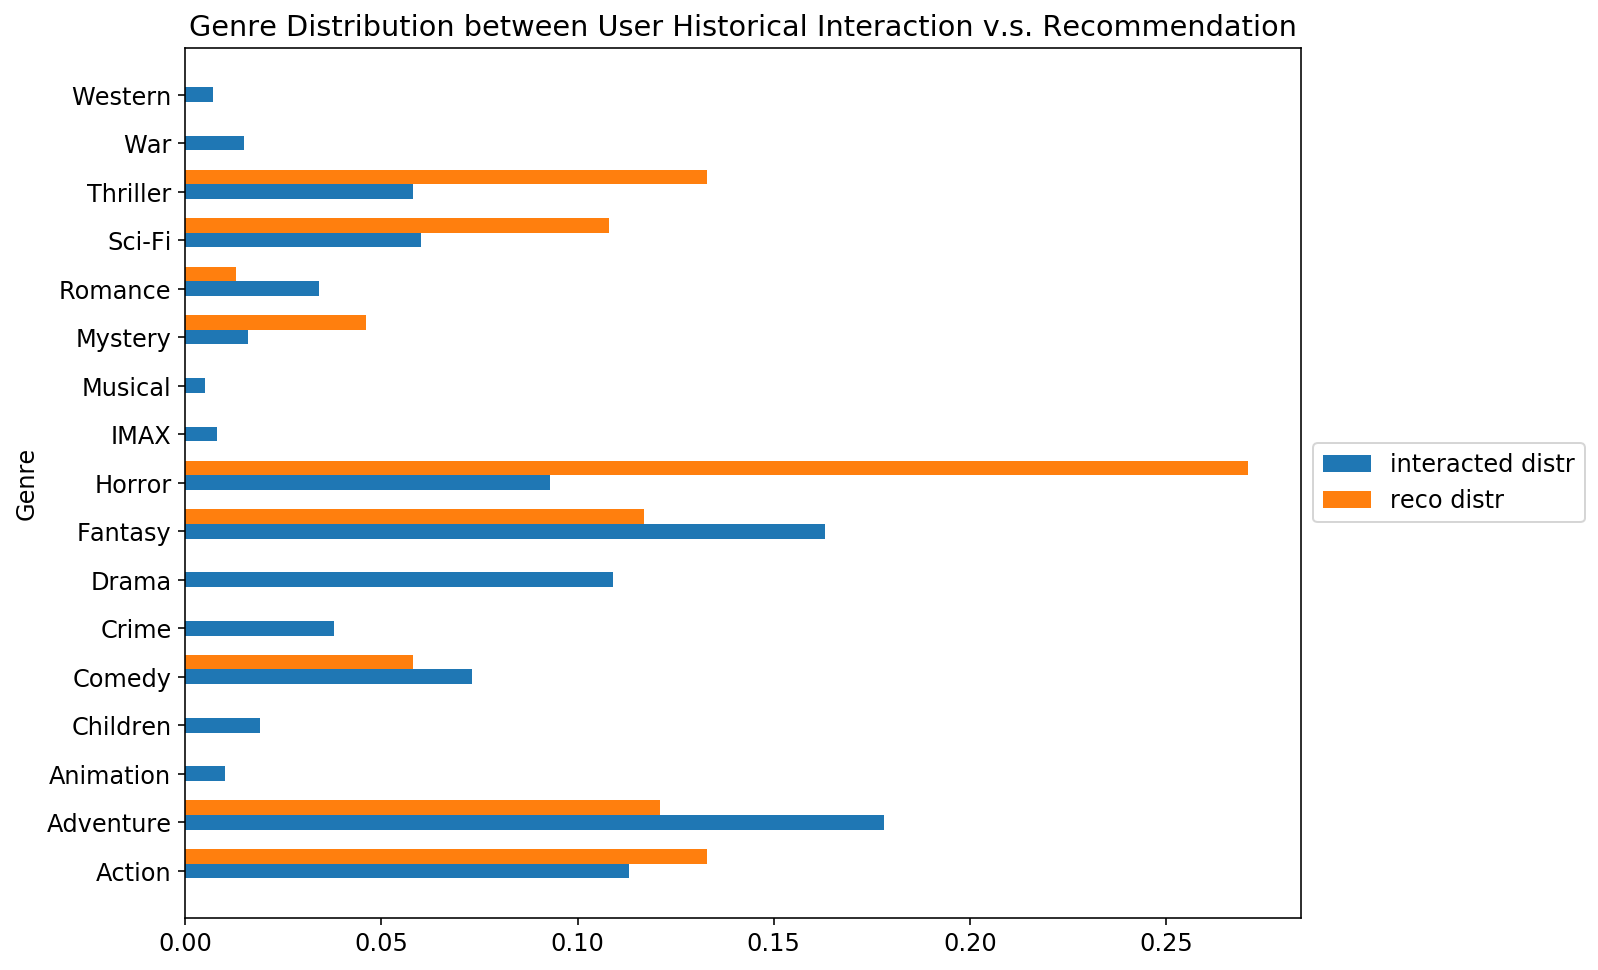

In [17]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 12


def distr_comparison_plot(interacted_distr, reco_distr, width=0.3):
    
    # the value will automatically be converted to a column with the
    # column name of '0'
    interacted = pd.DataFrame.from_dict(interacted_distr, orient='index')
    reco = pd.DataFrame.from_dict(reco_distr, orient='index')
    df = interacted.join(reco, how='outer', lsuffix='_interacted')

    n = df.shape[0]
    index = np.arange(n)
    plt.barh(index, df['0_interacted'], height=width, label='interacted distr')
    plt.barh(index + width, df['0'], height=width, label='reco distr')
    plt.yticks(index, df.index)
    plt.legend(bbox_to_anchor=(1, 0.5))
    plt.title('Genre Distribution between User Historical Interaction v.s. Recommendation')
    plt.ylabel('Genre')
    plt.show()
    
    
distr_comparison_plot(interacted_distr, reco_distr)

### Calibration Metric

Looking at the results above, we can see that according to $p(g|u)$, the user has interacted with genres such as War, Western, however, they are nowhere to be seen in the topn recommendation to the user, hence we can argue based on the output that our recommendation might not be that well calibrated to the user's past interaction.

To scale this type of comparison, we'll now define our calibration metric $C$. There are various methods to compare whether two distributions are similar to each other, and one popular choice is KL-divergence.

\begin{align}
C(p,q) = D_{KL}(p || q) = \sum_{g} p(g|u) \cdot \log \frac{p(g|u)}{\tilde{q}(g|u)}
\end{align}

The denominator in the formula should be $q(g|u)$, but given that the formula would be undefined if $q(g|u) = 0$ and $p(g|u) > 0$ for a genre $g$. We instead use:

\begin{align}
\tilde{q}(g|u) = (1 - \alpha) \cdot q(g|u) + \alpha \cdot p(g|u)
\end{align}

with a small $\alpha$ such as 0.01, so that $q(g|u) \approx \tilde{q}(g|u)$.

In [18]:
def compute_kl_divergence(interacted_distr, reco_distr, alpha=0.01):
    """
    KL (p || q), the lower the better.

    alpha is not really a tuning parameter, it's just there to make the
    computation more numerically stable.
    """
    kl_div = 0.
    for genre, score in interacted_distr.items():
        reco_score = reco_distr.get(genre, 0.)
        reco_score = (1 - alpha) * reco_score + alpha * score
        kl_div += score * np.log2(score / reco_score)

    return kl_div


compute_kl_divergence(interacted_distr, reco_distr)

1.3345197164266038

### Generating Calibrated Recommendations

Being able to compute the calibration metric between $p(g|u)$ and $q(g|u)$ is all well and good, but how can we generate a recommendation list that is more calibrated becomes the next important and interesting question.

Different recommendation algorithm's objective function might be completely different, thus instead of going to hard-route of incorporating it into the objective function right off the bat and spend two weeks writing the customized algorithm in an efficient manner, we will start with an alternative approach of re-ranking the predicted list of a recommender system in a post-processing step.

To determine the optimal set $I^*$ of $N$ recommended items, we'll be using maximum marginal relevance.

\begin{align}
I^* = \underset{I, |I|=N}{\text{argmax}} \; (1 - \lambda) \cdot s(I) - \lambda \cdot C(p, q(I))
\end{align}

Where

- $s(i)$ is the score of the items $i \in I$ predicted by the recommender system and $s(I) = \sum_{i \in I} s(i)$, i.e. the sum of all the items' score in the recommendation list.
- $\lambda \in [0, 1]$ is a tuning parameter that determines the trade-off between the score generated by the recommender and the calibration score, notice that since the calibration score is measured by KL-divergence, which is a metric that's the lower the better we use its negative in the maximization formula.

Finding the optimal set $I^*$ is a combinatorial optimization problem and can be a topic by itself. We won't do a deep dive into it, but instead leverage a popular greedy submodular optimization to solve this problem. The process is as follows:

- We start out with the empty set.
- Iteratively append one item $i$ at a time, and at step $n$, when we already have the set $I_{n-1}$ comprised of $n - 1$ items, the item $i$ that maximizes the objective function defined above for the set $I_{n-1} \cup {i}$ is added to obtain $I_n$
- Repeat the process the generate the full $I^*$ of size $N$.

From a theoretical standpoint, this procedure guarantees a solution that has a score of 0.63 of the optimal set.

With these information at hand, let's look at the implementation part:

In [19]:
def generate_item_candidates(model, user_item, user_id, index2item, item_mapping,
                             filter_already_liked_items=True):
    """
    For a given user, generate the list of items that we can recommend, during this
    step, we will also attach the recommender's score to each item.
    """
    n_items = user_item.shape[1]
    
    # this is how implicit's matrix factorization generates
    # the scores for each item for a given user, modify this
    # part of the logic if we were to use a completely different
    # algorithm to generate the ranked items
    user_factor = model.user_factors[user_id]
    scores = model.item_factors.dot(user_factor)

    liked = set()
    if filter_already_liked_items:
        liked = set(user_item[user_id].indices)

    item_ids = set(np.arange(n_items))
    item_ids -= liked

    items = []
    for item_id in item_ids:
        item = item_mapping[index2item[item_id]]
        item.score = scores[item_id]
        items.append(item)

    return items

In [20]:
items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
print('number of item candidates:', len(items))
items[:5]

number of item candidates: 20588


[Toy Story (1995),
 Jumanji (1995),
 Grumpier Old Men (1995),
 Waiting to Exhale (1995),
 Father of the Bride Part II (1995)]

In [21]:
def compute_utility(reco_items, interacted_distr, lmbda=0.5):
    """
    Our objective function for computing the utility score for
    the list of recommended items.

    lmbda : float, 0.0 ~ 1.0, default 0.5
        Lambda term controls the score and calibration tradeoff,
        the higher the lambda the higher the resulting recommendation
        will be calibrated. Lambda is keyword in Python, so it's
        lmbda instead ^^
    """
    reco_distr = compute_genre_distr(reco_items)
    kl_div = compute_kl_divergence(interacted_distr, reco_distr)

    total_score = 0.0
    for item in reco_items:
        total_score += item.score
    
    # kl divergence is the lower the better, while score is
    # the higher the better so remember to negate it in the calculation
    utility = (1 - lmbda) * total_score - lmbda * kl_div
    return utility

In [22]:
def calib_recommend(items, interacted_distr, topn, lmbda=0.5):
    """
    start with an empty recommendation list,
    loop over the topn cardinality, during each iteration
    update the list with the item that maximizes the utility function.
    """
    calib_reco = []
    for _ in range(topn):
        max_utility = -np.inf
        for item in items:
            if item in calib_reco:
                continue

            utility = compute_utility(calib_reco + [item], interacted_distr, lmbda)
            if utility > max_utility:
                max_utility = utility
                best_item = item

        calib_reco.append(best_item)
        
    return calib_reco

In [23]:
start = time.time()
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda=0.99)
elapsed = time.time() - start
print('elapsed: ', elapsed)
calib_reco_items

elapsed:  18.013550996780396


[Aelita: The Queen of Mars (Aelita) (1924),
 Rubber (2010),
 Valiant (2005),
 Hellboy (2004),
 Tai Chi Hero (2012),
 Descent, The (2005),
 Jason and the Argonauts (1963),
 Happy New Year (2014),
 Godzilla vs. Mothra (Mosura tai Gojira) (1964),
 Picture of Dorian Gray, The (1945),
 Lost Boys, The (1987),
 Beastmaster, The (1982),
 Enemy Mine (1985),
 Hound of the Baskervilles, The (1959),
 Highlander (1986),
 Dracula (Bram Stoker's Dracula) (1992),
 Last Starfighter, The (1984),
 NeverEnding Story, The (1984),
 Dune (2000),
 Evil Dead II (Dead by Dawn) (1987)]

In the code chunk above, we turned the $\lambda$ knob extremely high to generate the most calibrated recommendation list possible. Let's now compare the calibrated recommendation (which only optimizes for score, $s$), the original recommendation and the user's interaction distribution.


original reco kl-divergence score: 1.3345197164266038
calibrated reco kl-divergence score: 0.025585815111015126


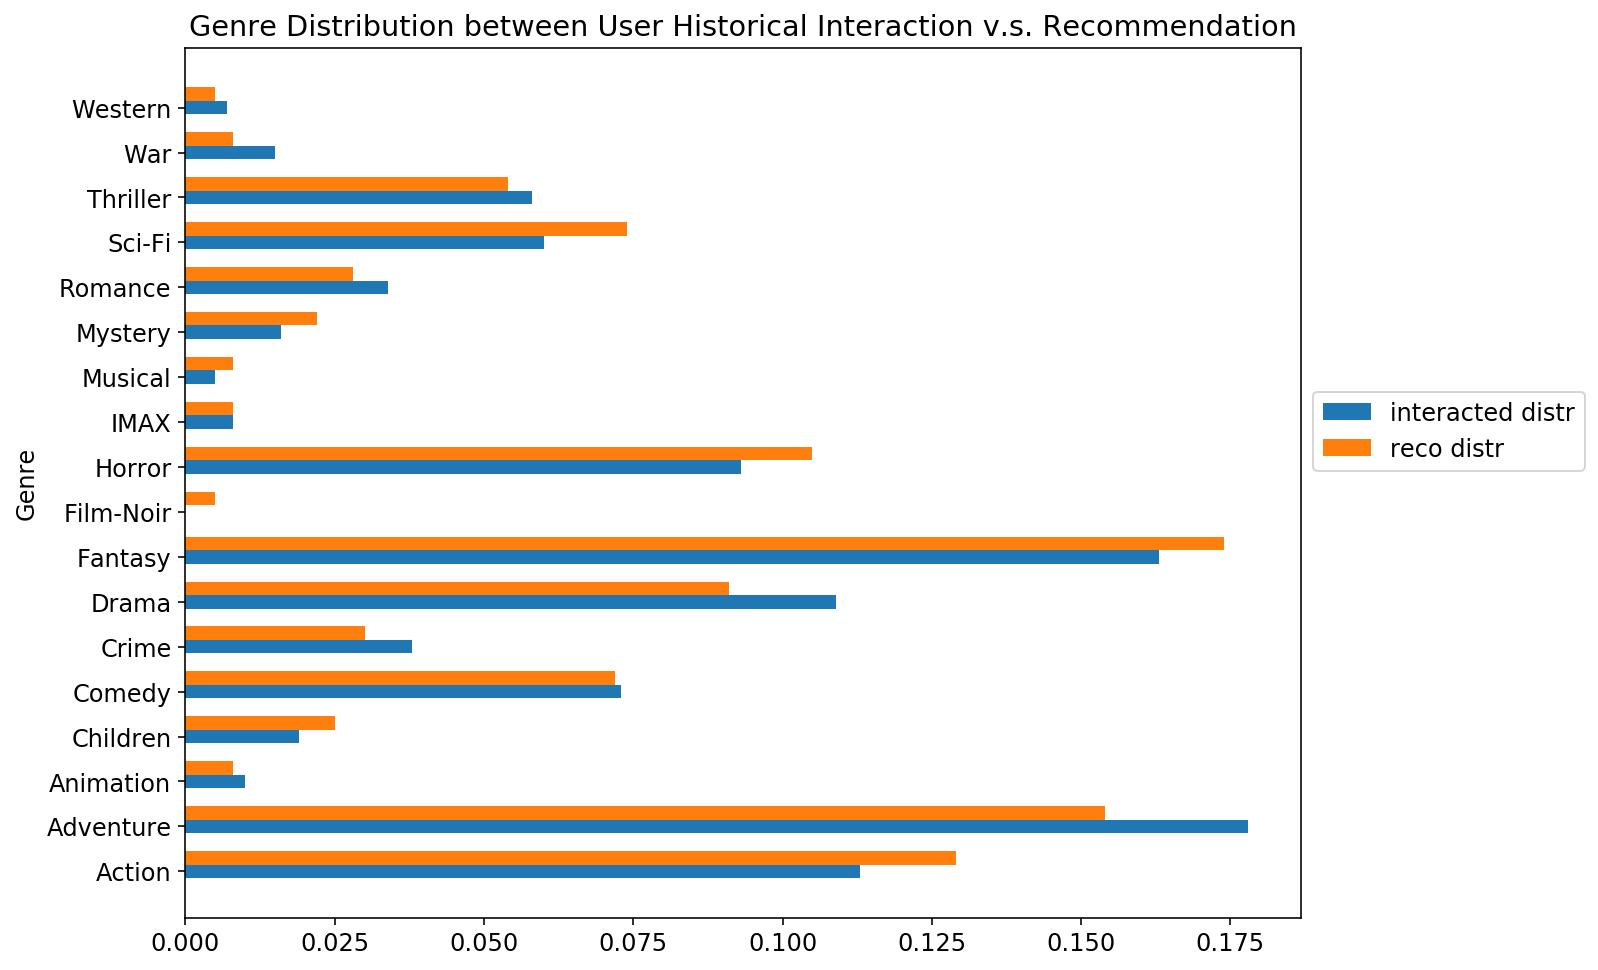

In [24]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
reco_kl_div = compute_kl_divergence(interacted_distr, reco_distr)
print('\noriginal reco kl-divergence score:', reco_kl_div)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)

distr_comparison_plot(interacted_distr, calib_reco_distr)

Printing out the genre distribution from the calibrated recommendation list shows that this list covers more genre and its distribution closely resembles the distribution of the user's past historical interaction and our quantitative calibration metric, KL-divergence also confirms this. i.e. the calibrated recommendation's KL-divergence is lower than the original recommendation's score.
 
Thankfully from the results above, it seems that the re-ranked recommendation list that aims to maximize calibration score does in fact generate a more calibrated list. But the question is at what cost? Does other ranking metrics that recommender system often optimize for drop? Let's take a look at precision_at_k. Here the number for `k` is the `topn` parameter that we've defined earlier. i.e. the number of recommendations to generate for the user.

In [25]:
def precision(user_item, user_id, reco_items, index2item):
    indptr = user_item.indptr
    indices = user_item.indices

    reco_ids = {item.id for item in reco_items}
    likes = {index2item[indices[i]] for i in range(indptr[user_id], indptr[user_id + 1])}

    relevant = len(reco_ids & likes)
    total = min(len(reco_items), len(likes))
    return relevant / total

In [26]:
reco_precision = precision(user_item_test, user_id, reco_items, index2item)
calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
print('original reco precision score:', reco_precision)
print('calibrated reco precision score:', calib_reco_precision)

original reco precision score: 0.1875
calibrated reco precision score: 0.125


Well ..., it's not a surprise that the calibrated recommendation list's precision score is a bit disappointing compared to the original recommendation. But let's see if we try a different value of $\lambda$, this time turning it down a bit to strike a balance between calibration and precision.

In [27]:
start = time.time()
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda=0.5)
elapsed = time.time() - start
print('elapsed: ', elapsed)
calib_reco_items

elapsed:  15.620396137237549


[Jason and the Argonauts (1963),
 Lost Boys, The (1987),
 Dune (2000),
 Godzilla vs. Mothra (Mosura tai Gojira) (1964),
 Dracula (Bram Stoker's Dracula) (1992),
 Evil Dead, The (1981),
 Evil Dead II (Dead by Dawn) (1987),
 Hellraiser (1987),
 Secret of NIMH, The (1982),
 Ringu (Ring) (1998),
 Beastmaster, The (1982),
 Highlander (1986),
 Flash Gordon (1980),
 American Werewolf in London, An (1981),
 Invasion of the Body Snatchers (1978),
 Road Warrior, The (Mad Max 2) (1981),
 Krull (1983),
 Phenomena (a.k.a. Creepers) (1985),
 Last Starfighter, The (1984),
 Serpent and the Rainbow, The (1988)]

In [28]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)
print('calibrated reco precision score:', calib_reco_precision)

calibrated reco kl-divergence score: 0.6256542329089019
calibrated reco precision score: 0.1875


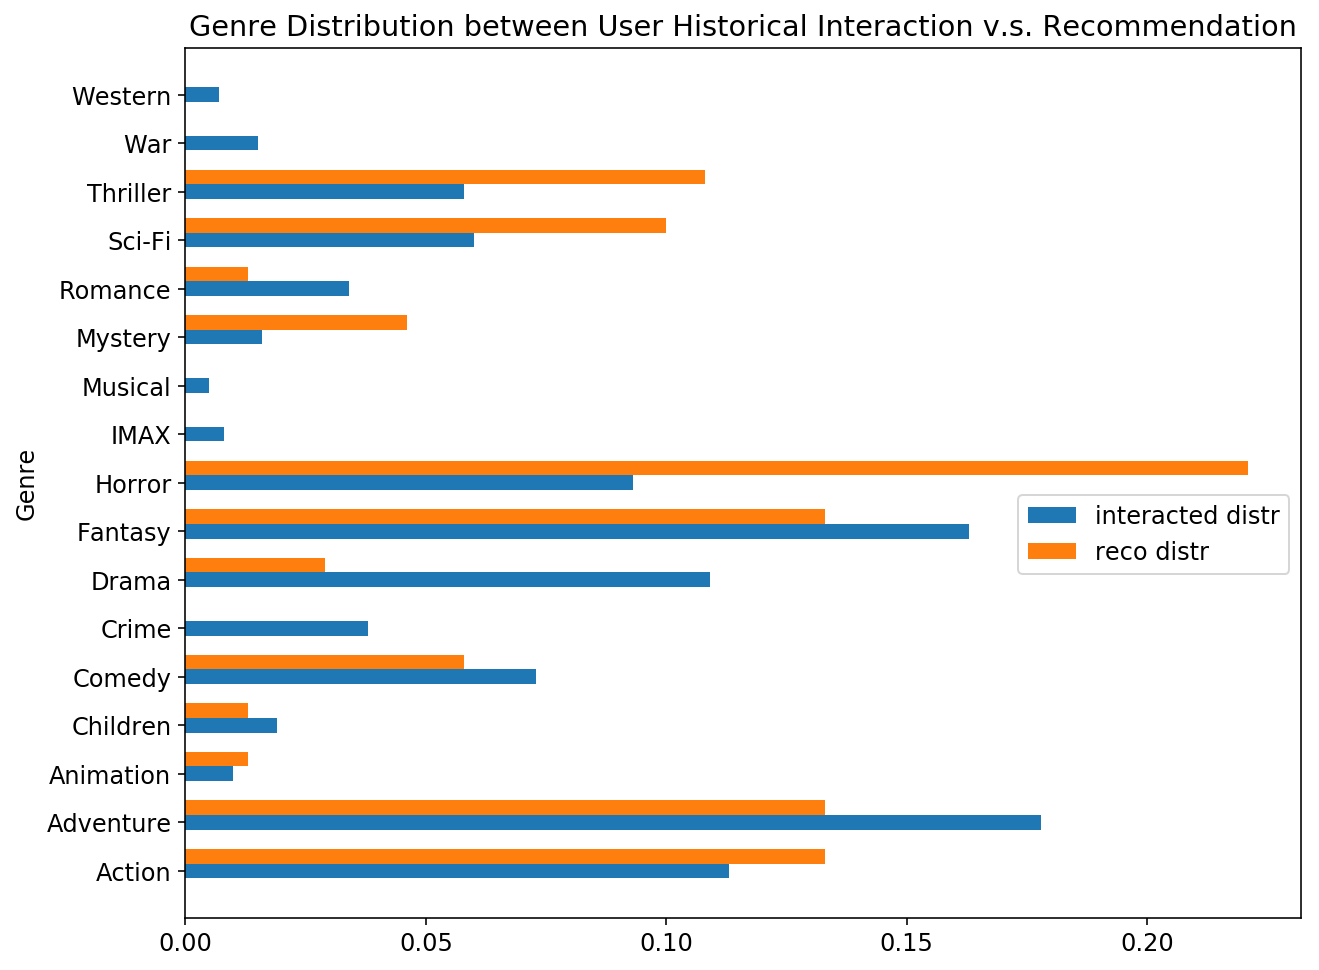

In [29]:
calib_reco_distr = compute_genre_distr(calib_reco_items)
distr_comparison_plot(interacted_distr, calib_reco_distr)

Well, well, well. It turns out calibration can be improved considerably while accuracy is reduced only slightly if we find the sweet spot for the tuning parameter $\lambda$.

The following code chunk curates all the code to generate the calibrated recommendation, the original recommendation and compare it with the user's historical interaction in one place for ease of tracking the flow. This process is outlined for 1 user, feel free to modify the code to perform this comparison across all users and due to the randomness in the recommendation algorithm, the results might differ across runs, but the underlying trend should remain the same.

calibrated reco kl-divergence score: 0.025585815111015126
calibrated reco precision score: 0.125


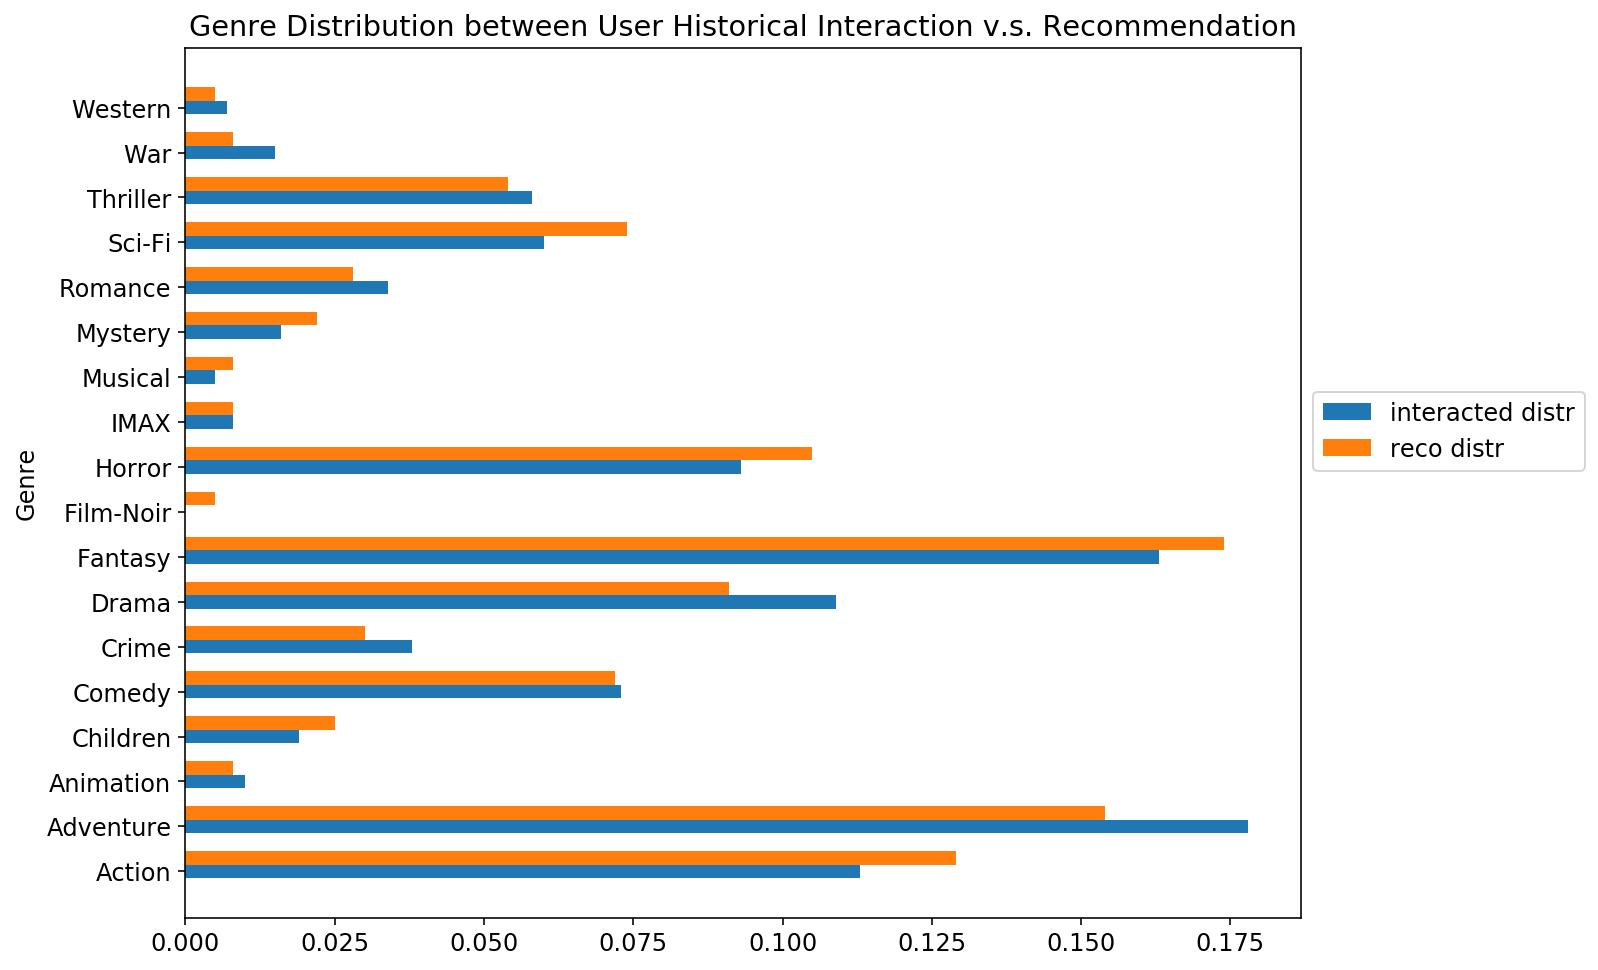

original reco kl-divergence score: 1.3345197164266038
original reco precision score: 0.1875


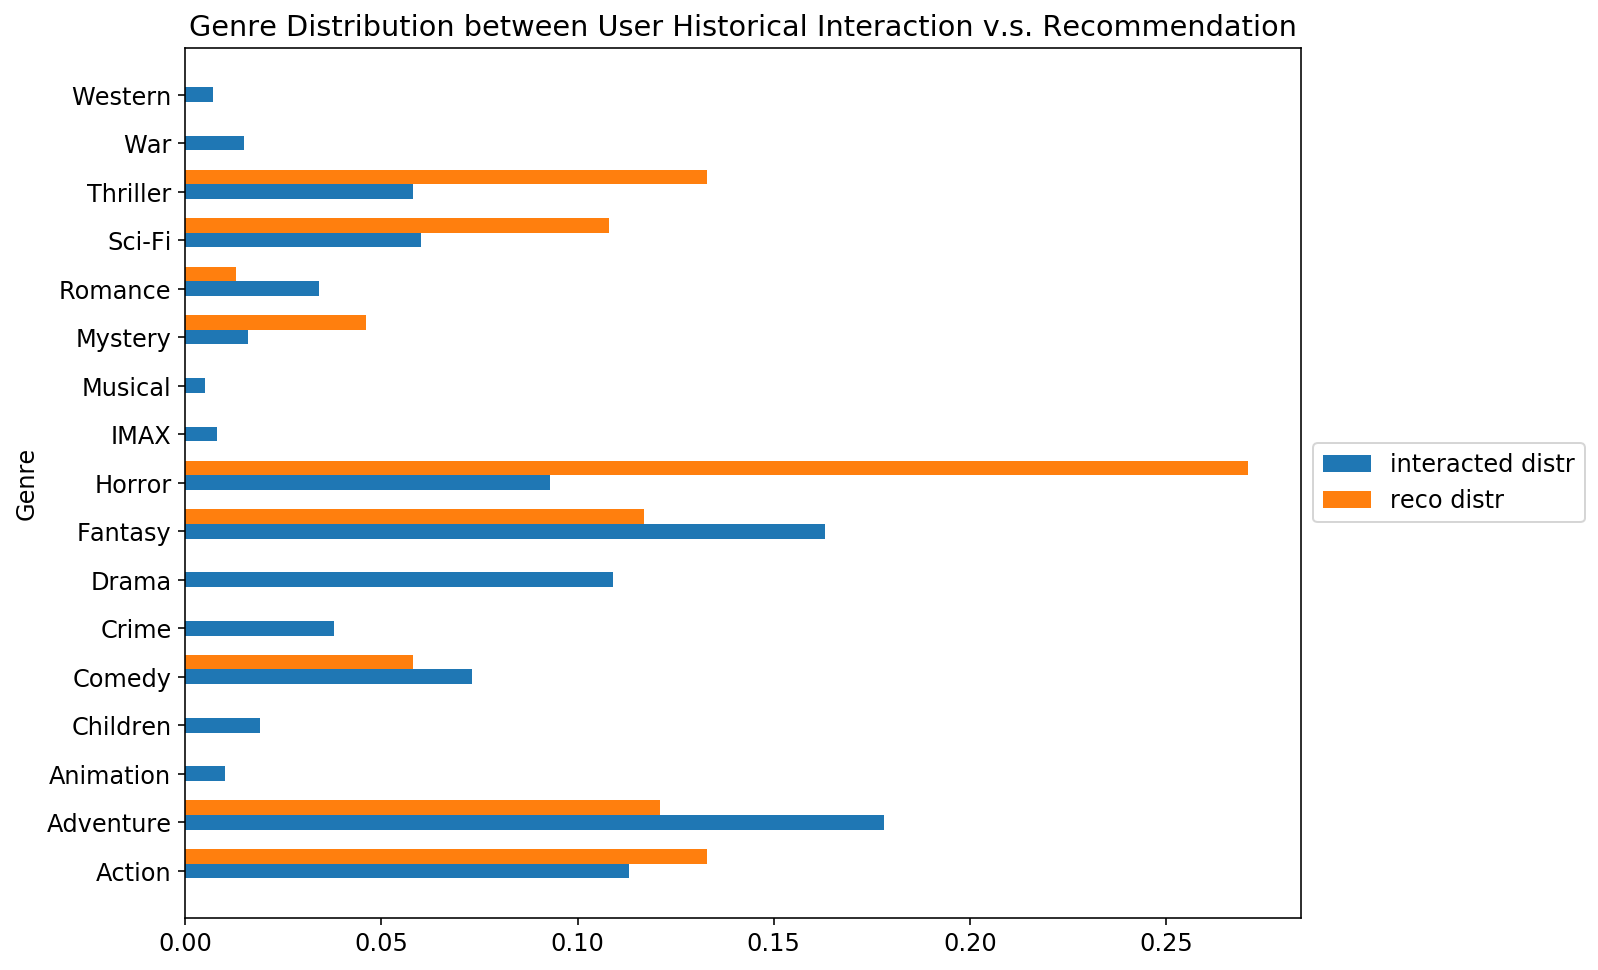

In [30]:
topn = 20
user_id = 0
lmbda = 0.99

reco = bpr.recommend(user_id, user_item_train, N=topn)
reco_items = [item_mapping[index2item[index]] for index, _ in reco]
reco_distr = compute_genre_distr(reco_items)

interacted_ids = user_item_train[user_id].nonzero()[1]
interacted_items = [item_mapping[index2item[index]] for index in interacted_ids]
interacted_distr = compute_genre_distr(interacted_items)

items = generate_item_candidates(bpr, user_item_train, user_id, index2item, item_mapping)
calib_reco_items = calib_recommend(items, interacted_distr, topn, lmbda)
calib_reco_distr = compute_genre_distr(calib_reco_items)

calib_reco_kl_div = compute_kl_divergence(interacted_distr, calib_reco_distr)
calib_reco_precision = precision(user_item_test, user_id, calib_reco_items, index2item)
print('calibrated reco kl-divergence score:', calib_reco_kl_div)
print('calibrated reco precision score:', calib_reco_precision)
distr_comparison_plot(interacted_distr, calib_reco_distr)

reco_kl_div = compute_kl_divergence(interacted_distr, reco_distr)
reco_precision = precision(user_item_test, user_id, reco_items, index2item)
print('original reco kl-divergence score:', reco_kl_div)
print('original reco precision score:', reco_precision)
distr_comparison_plot(interacted_distr, reco_distr)

## End Note

We have calibrated our recommendation here based on movies' genre but the same idea can be applied if we wish to calibrate our recommendation based on some other traits that matters for the problem at hand.

The approach we took here is from a user-centric perspective, i.e. we are generating calibrated recommendations for each user, we can also tackle the problem from a item-centric perspective to see if items are recommended properly, e.g. if popular items just gets recommended a lot more times than other items.

Although we used Bayesian Personalized Ranking to generated recommendations for each user, the technique that we used here to generated the calibrated ranked items for each user is independent of the recommendation algorithm we use. We're only using the algorithm here to demonstrate the process, so feel free is try this out on a recommendation algorithm of your liking/interest.

The discussion here focused on generating calibrated recommendation anchored on a user's past interaction. So if a user played 70% romance movies and 30% action movies, then when we say our recommendation is well-calibrated, that means the top ranked movies for the user should also consists of 70% romance movies and 30% action movies. We can, however, expand this work to recommend diversified items/movies. In other words, instead of limiting ourselves to only work with romance and action movies for a user that has only played movies falling under these two genres, we recommend movies from genres that are outside the user's historical play list.

To elaborate, we were using $p(g|u)$ to represent the user's historical genre interaction, we can extend that distribution to $\tilde{p}(g|u)$, where:

\begin{align}
\tilde{p}(g|u) = \beta \cdot p_0(g) + (1 - \beta) \cdot p(g|u)
\end{align}

Here $p_0(g)$ denote a prior distribution that takes positive values for all the genres $g$ in which we would like to promote diversity in the recommendation. Again we also have a tuning parameter $\beta \in [0, 1]$ to control how "diversified" we would like our recommendations to be. As to how we decide which genres to promote diversity for? Well, that's a topic for another day, but to start with we can use a uniform distribution across all genres or the average over all the users' genre distribution.

After reading a lot of tutorials/papers that introduces new algorithms or new libraries/packages that boosts model performance in terms of ranking metric, coming across a paper on a different topic, calibrating recommendation, is a breath of fresh air. This sheds a new light on how I think about serving recommendations, so kudos to the original authors who brought this well-written paper to light. I encourage people to read the original paper if interested. [Paper: H. Steck - Calibrated Recommendation (2018)](https://dl.acm.org/citation.cfm?id=3240372)

**Side Note:**

- In the generating calibrated recommendation section, we introduced the maximum marginal relevance formula that has the knob for us to tune the balance between our original recommendation algorithm's score versus the calibration score. This "balancing" notion can actually be applied to many different areas. For example, In the original paper that introduced this idea, they were using this formula in the context of a search engine. To elaborate, when issuing a query on a search engine, the search engine often times assembles results that maximizes the relevance to the user query. By introducing the linear combination "marginal relevance" - a result is now said to have high marginal relevance if it is both relevant to the query and contains minimal similarity to previously selected results.
- The Greedy Algorithm we leveraged to actually generate our top-N items that maximizes the maximum marginal relevance formula is a discrete optimization method that's often times referred to as a submodular optimization. Submodular optimization is a generic optimization method that can also be applied to other areas such as influence maximization and can be a topic by itself and is discussed lightly deeper in another notebook. [Notebook: Submodular Optimization & Influence Maximization](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/networkx/max_influence/max_influence.ipynb)

# Reference

- [Paper: H. Steck - Calibrated Recommendation (2018)](https://dl.acm.org/citation.cfm?id=3240372)
- [Paper: J. Carbonell, J. Goldstein - The use of MMR, diversity-based reranking for
reordering documents and producing summaries (1998)](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.188.3982&rep=rep1&type=pdf)